# Task 4: Basic Analysis of EEG Signals

This task focuses on extracting time-domain features from the EEG signals provided in the dataset. The required features to be computed include:

1. **Mean**  
2. **Zero Crossing Rate**  
3. **Range**  
4. **Energy**  
5. **RMS (Root Mean Square)**  
6. **Variance**

## Workflow Overview

### 1. Data Loading  
The EEG data is loaded using the `Dataset` and `DataLoader` utilities from the PyTorch library. This ensures efficient handling and processing of the dataset.

### 2. Data Preparation  
After loading, the data is converted into a NumPy array format to facilitate feature extraction.

### 3. Feature Extraction  
Two utility functions are employed for this process:

- **`calculateparams`**  
  This function takes the loaded data as input and computes a list of the specified features for the given sample data.

- **`plot`**  
  This function visualizes the loaded data by plotting a sample data point with its channels displayed both separately and combined. Additionally, it returns a Pandas DataFrame containing all features of the plotted data point.

### 4. Feature Inspection  
Using `pandas.describe()`, the extracted features of the plotted data point can be summarized and visually inspected. This provides insights into the characteristics of the signal.

### 5. Feature Compilation  
The features for each class are organized into a list, allowing for easy access and further analysis if needed.

### 6. Saving Extracted Features
The extracted features for each dataset are saved into separate CSV files.

---

This structured approach ensures accurate computation and clear visualization of the EEG signal features, facilitating deeper insights into the dataset.


# 1. Importing required libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
from torch.utils.data import Dataset, DataLoader
from scipy import interpolate

# 2. Utility functions


In [3]:
def calculateparams(loaded_data):
    feature_list = []
    
    for i in range(loaded_data.shape[0]):
        channel_data = loaded_data[i]
        
        mean = np.mean(channel_data)
        zero_crossings = np.sum(np.diff(np.sign(channel_data)) != 0)
        value_range = np.ptp(channel_data)
        energy = np.sum(channel_data**2)
        rms = np.sqrt(np.mean(channel_data**2))
        variance = np.var(channel_data)
        
        feature_list.append({
            "Channel": f"Channel {i+1}",
            "Mean": mean,
            "Zero Crossing Rate": zero_crossings,
            "Range": value_range,
            "Energy": energy,
            "RMS": rms,
            "Variance": variance
        })

    return feature_list

def plot(loaded_data):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=20, ncols=1, figsize=(12, 24), gridspec_kw={"height_ratios": [1] + [0.5]*19})
           
    # Plot each channel in its own subplot
    for i in range(19):
        axes[0].plot(loaded_data[i], label=f"Channel {i+1}")
        axes[0].legend(loc="upper right", fontsize=8, ncol=3)
        axes[0].set_ylabel("Amplitude")
        axes[0].grid(True)
        
        axes[i+1].plot(loaded_data[i], label=f"Channel {i+1}")
        axes[i+1].legend(loc="upper right", fontsize=8)
        axes[i+1].set_ylabel(f"Ch {i+1}")
        axes[i+1].grid(True)
        
        # Make x-ticks and y-ticks more readable
        axes[i+1].tick_params(axis='x', labelsize=10)  # Set x-tick label font size
        axes[i+1].tick_params(axis='y', labelsize=10)  # Set y-tick label font size (if y-ticks exist)
    
    # Improve the x-axis ticks for all subplots
    axes[0].tick_params(axis='x', labelsize=10)  # Top subplot x-ticks
    
    # Add a common x-axis label
    plt.xlabel("Samples", fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()
    
    metrics_list = calculateparams(loaded_data)
    # Create a Pandas DataFrame from the metrics list
    return pd.DataFrame(metrics_list)

# 3. Data loading

In [4]:
class NPYDataset(Dataset):
    """
    Custom PyTorch Dataset to load data from multiple .npy files.
    """
    def __init__(self, directory):
        """
        Args:
            directory (str): Path to the directory containing .npy files.
        """
        self.directory = directory
        self.file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
        self.file_paths.sort()  # Ensure consistent ordering

    def __len__(self):
        """Return the total number of .npy files."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Load and return a single .npy file's data and its label (if applicable).
        Args:
            idx (int): Index of the file to load.
        
        Returns:
            np.ndarray: Data from the .npy file.
        """
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        label = os.path.basename(file_path).split('.')[0]  # Example: Use the file name as a label
        return data, label

In [5]:
# Define the directory containing the .npy files
normal_data_directory = "/kaggle/input/impulse/Impulse/EEG_Data/train_data/Normal"  
cps_data_directory = "/kaggle/input/impulse/Impulse/EEG_Data/train_data/Complex_Partial_Seizures"
video_data_directory = "/kaggle/input/impulse/Impulse/EEG_Data/train_data/Video_detected_Seizures_with_no_visual_change_over_EEG"
seizure_data_directory = "/kaggle/input/impulse/Impulse/EEG_Data/train_data/Electrographic_Seizures"
normal_withnoise_directory = "/kaggle/input/impulse/Impulse/EEG_Data/noisy_train_data/Normal"
# Create the dataset and dataloader
normaldataset = NPYDataset(normal_data_directory)
cpsdataset = NPYDataset(cps_data_directory)
videodataset = NPYDataset(video_data_directory)
seizuredataset = NPYDataset(seizure_data_directory)
normalnoisedataset = NPYDataset(normal_withnoise_directory)

In [6]:
dataloader = DataLoader(normaldataset, batch_size=1, shuffle=True)
normaleg, _ = next(iter(dataloader))
normal_data = np.array(normaleg).squeeze()

dataloader = DataLoader(cpsdataset, batch_size=1, shuffle=True)
cpseg, _ = next(iter(dataloader))
cps_data = np.array(cpseg).squeeze()

dataloader = DataLoader(videodataset, batch_size=1, shuffle=True)
videoeg, _ = next(iter(dataloader))
video_data = np.array(videoeg).squeeze()

dataloader = DataLoader(seizuredataset, batch_size=1, shuffle=True)
seizureeg, _ = next(iter(dataloader))
seizure_data = np.array(seizureeg).squeeze()

noiseg,_ = normalnoisedataset[8]
noise_data = np.array(noiseg)


# 4. Plotting the data

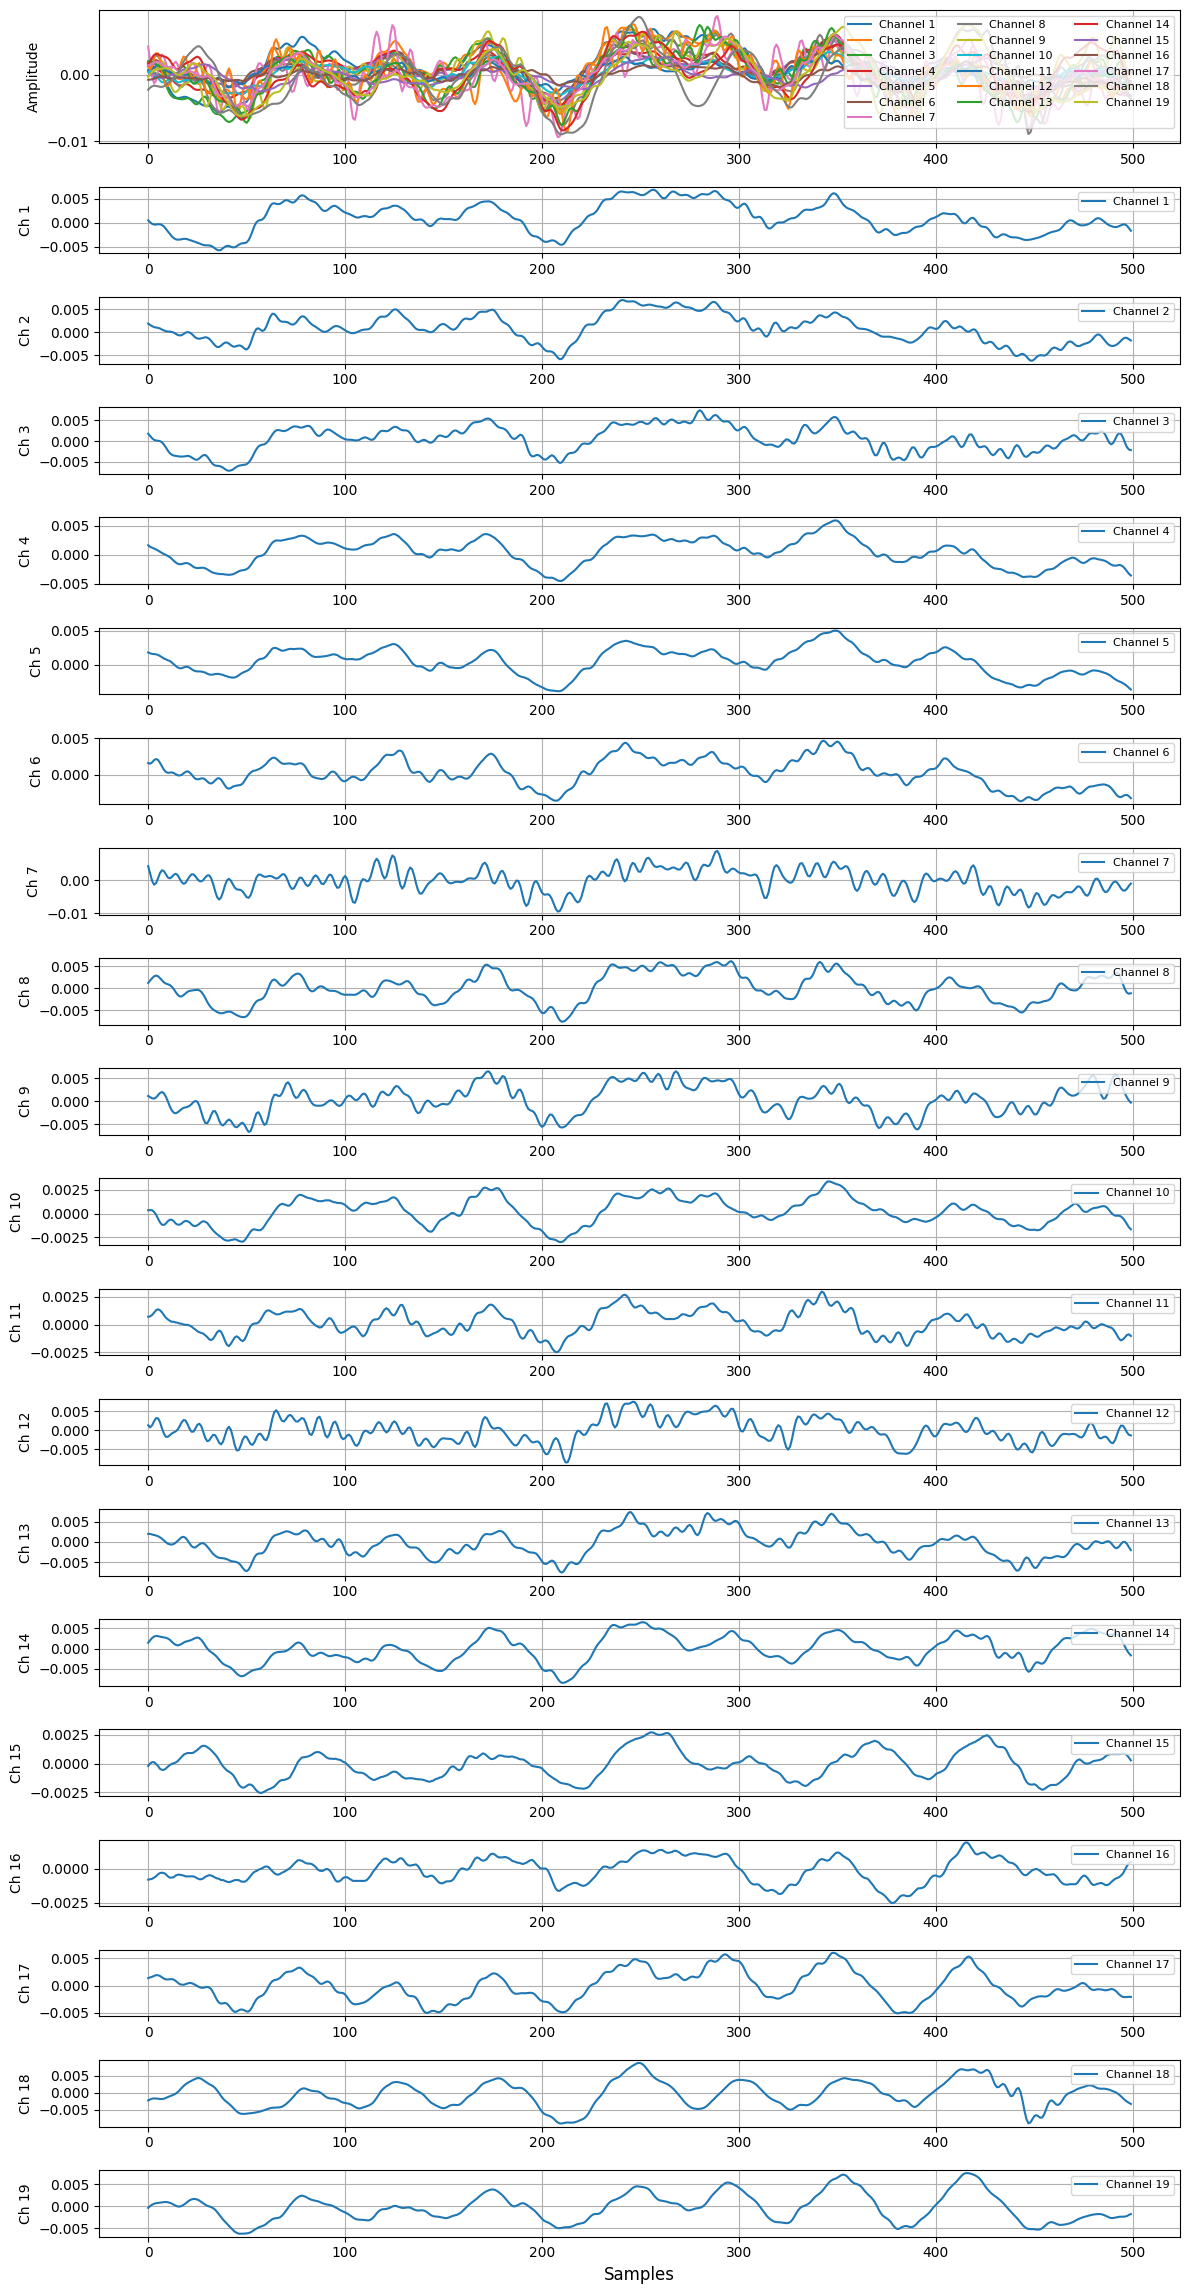

In [7]:
norm = plot(normal_data)

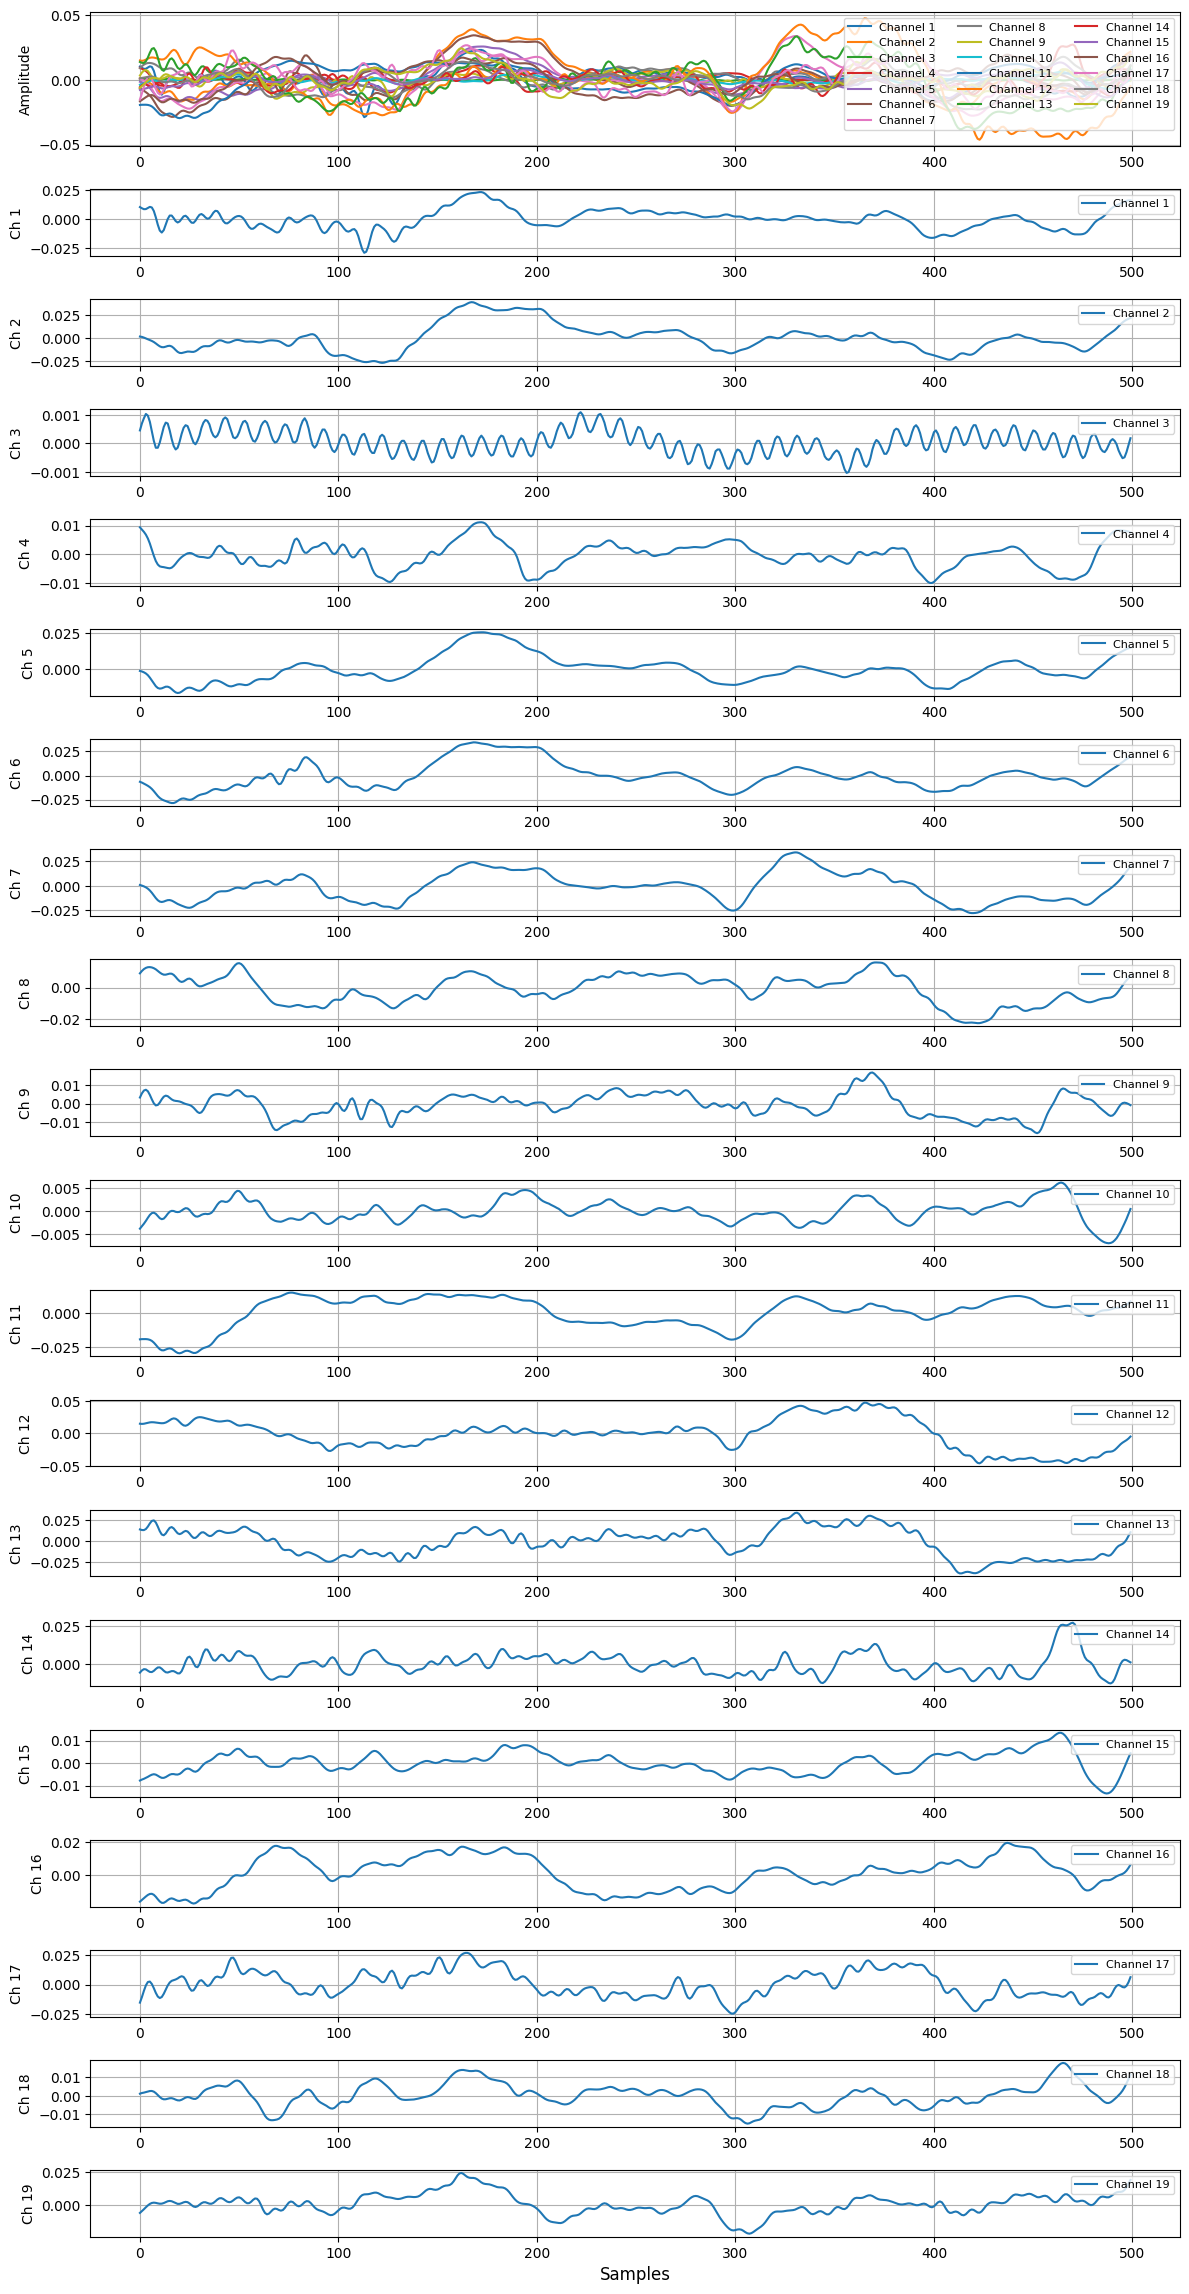

In [8]:
cps = plot(cps_data)

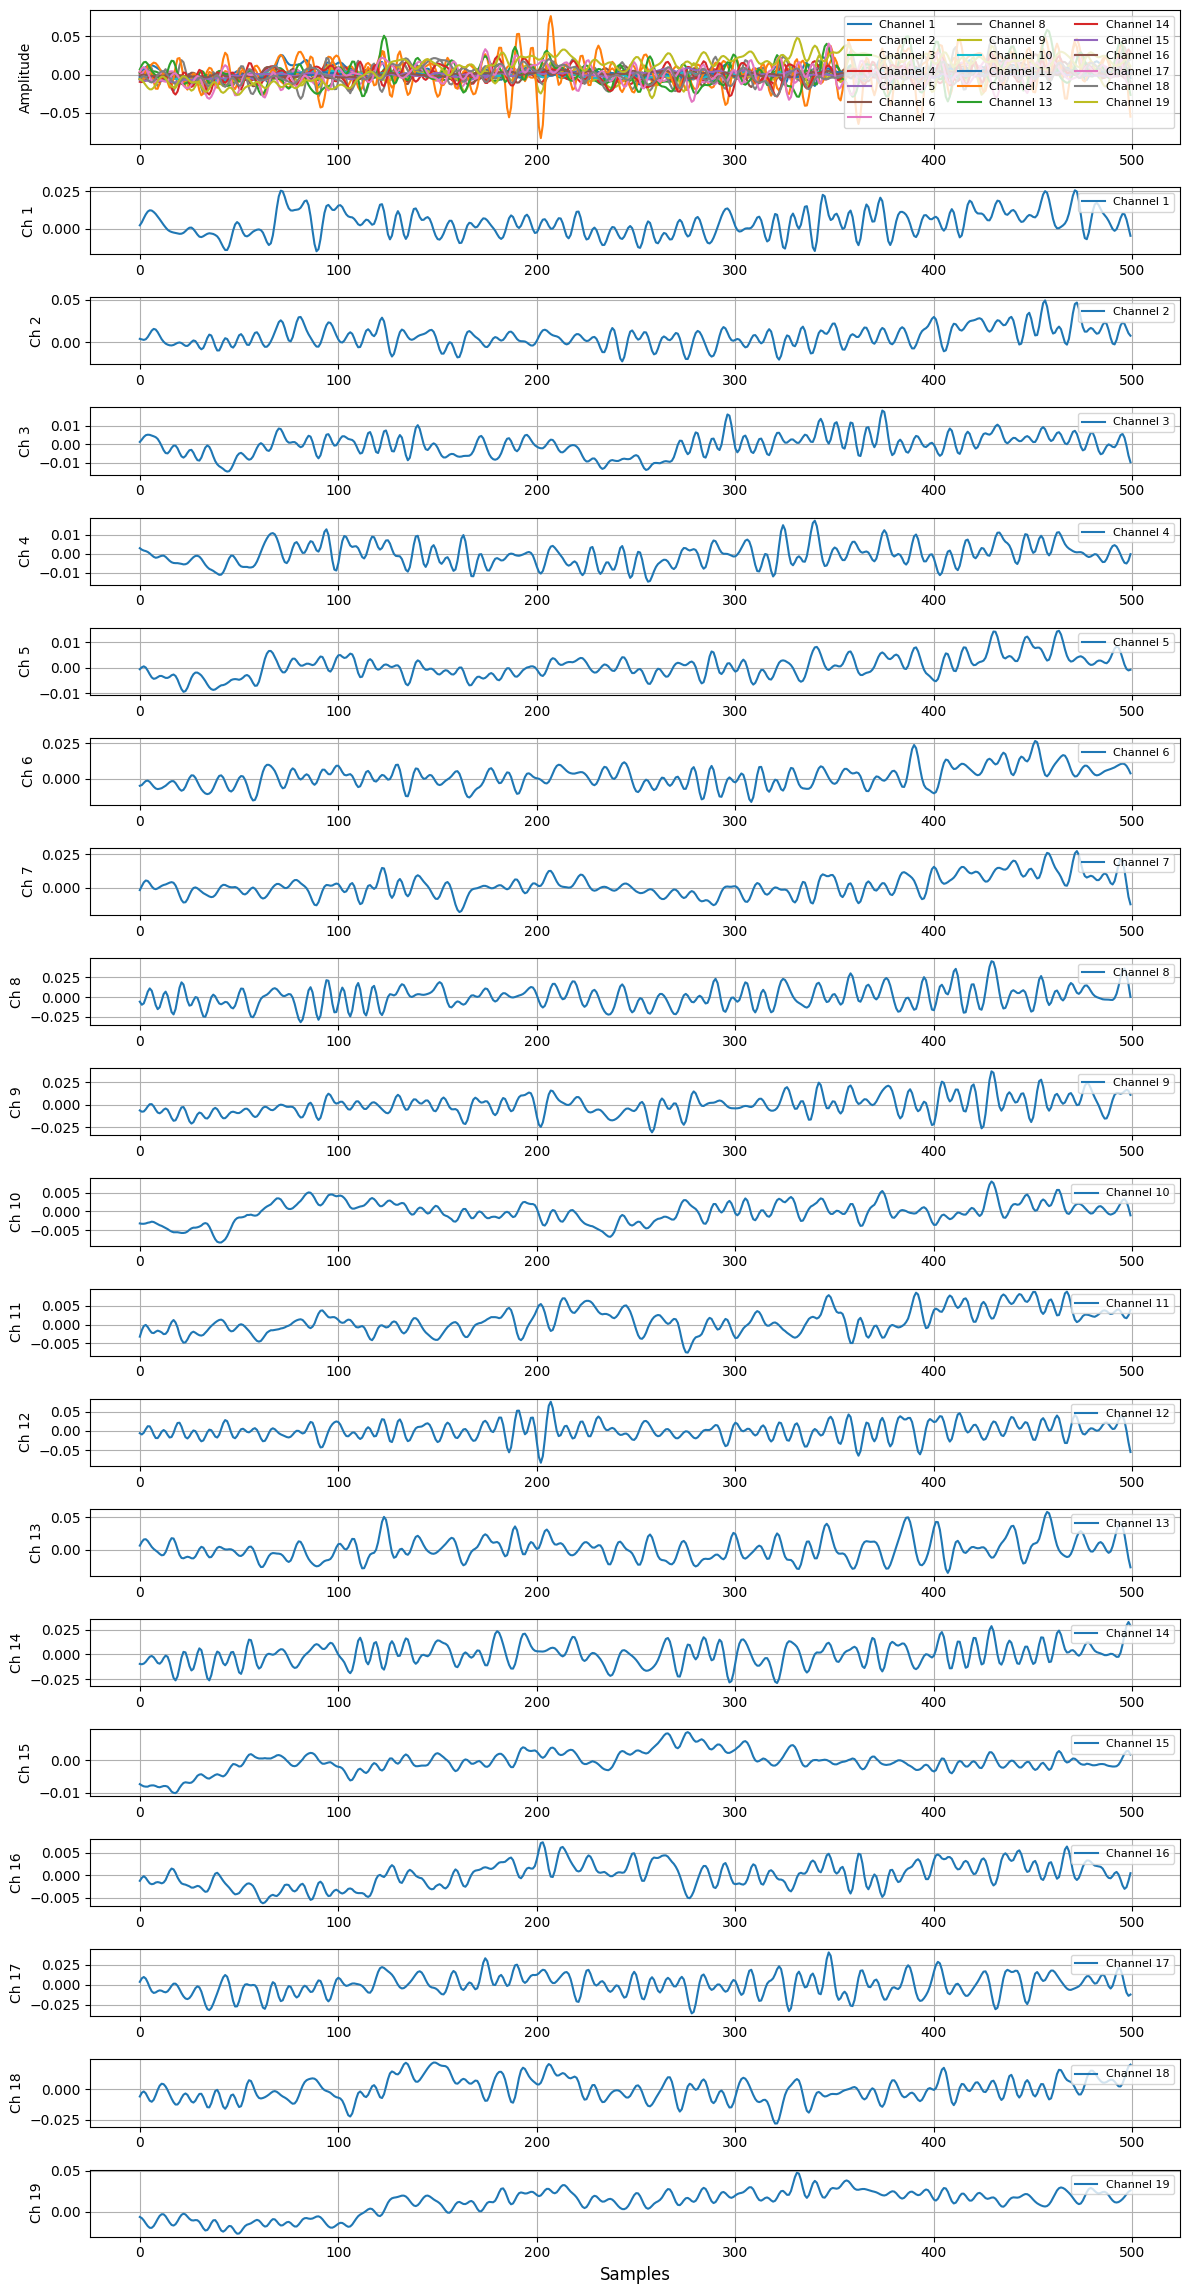

In [20]:
video = plot(video_data)

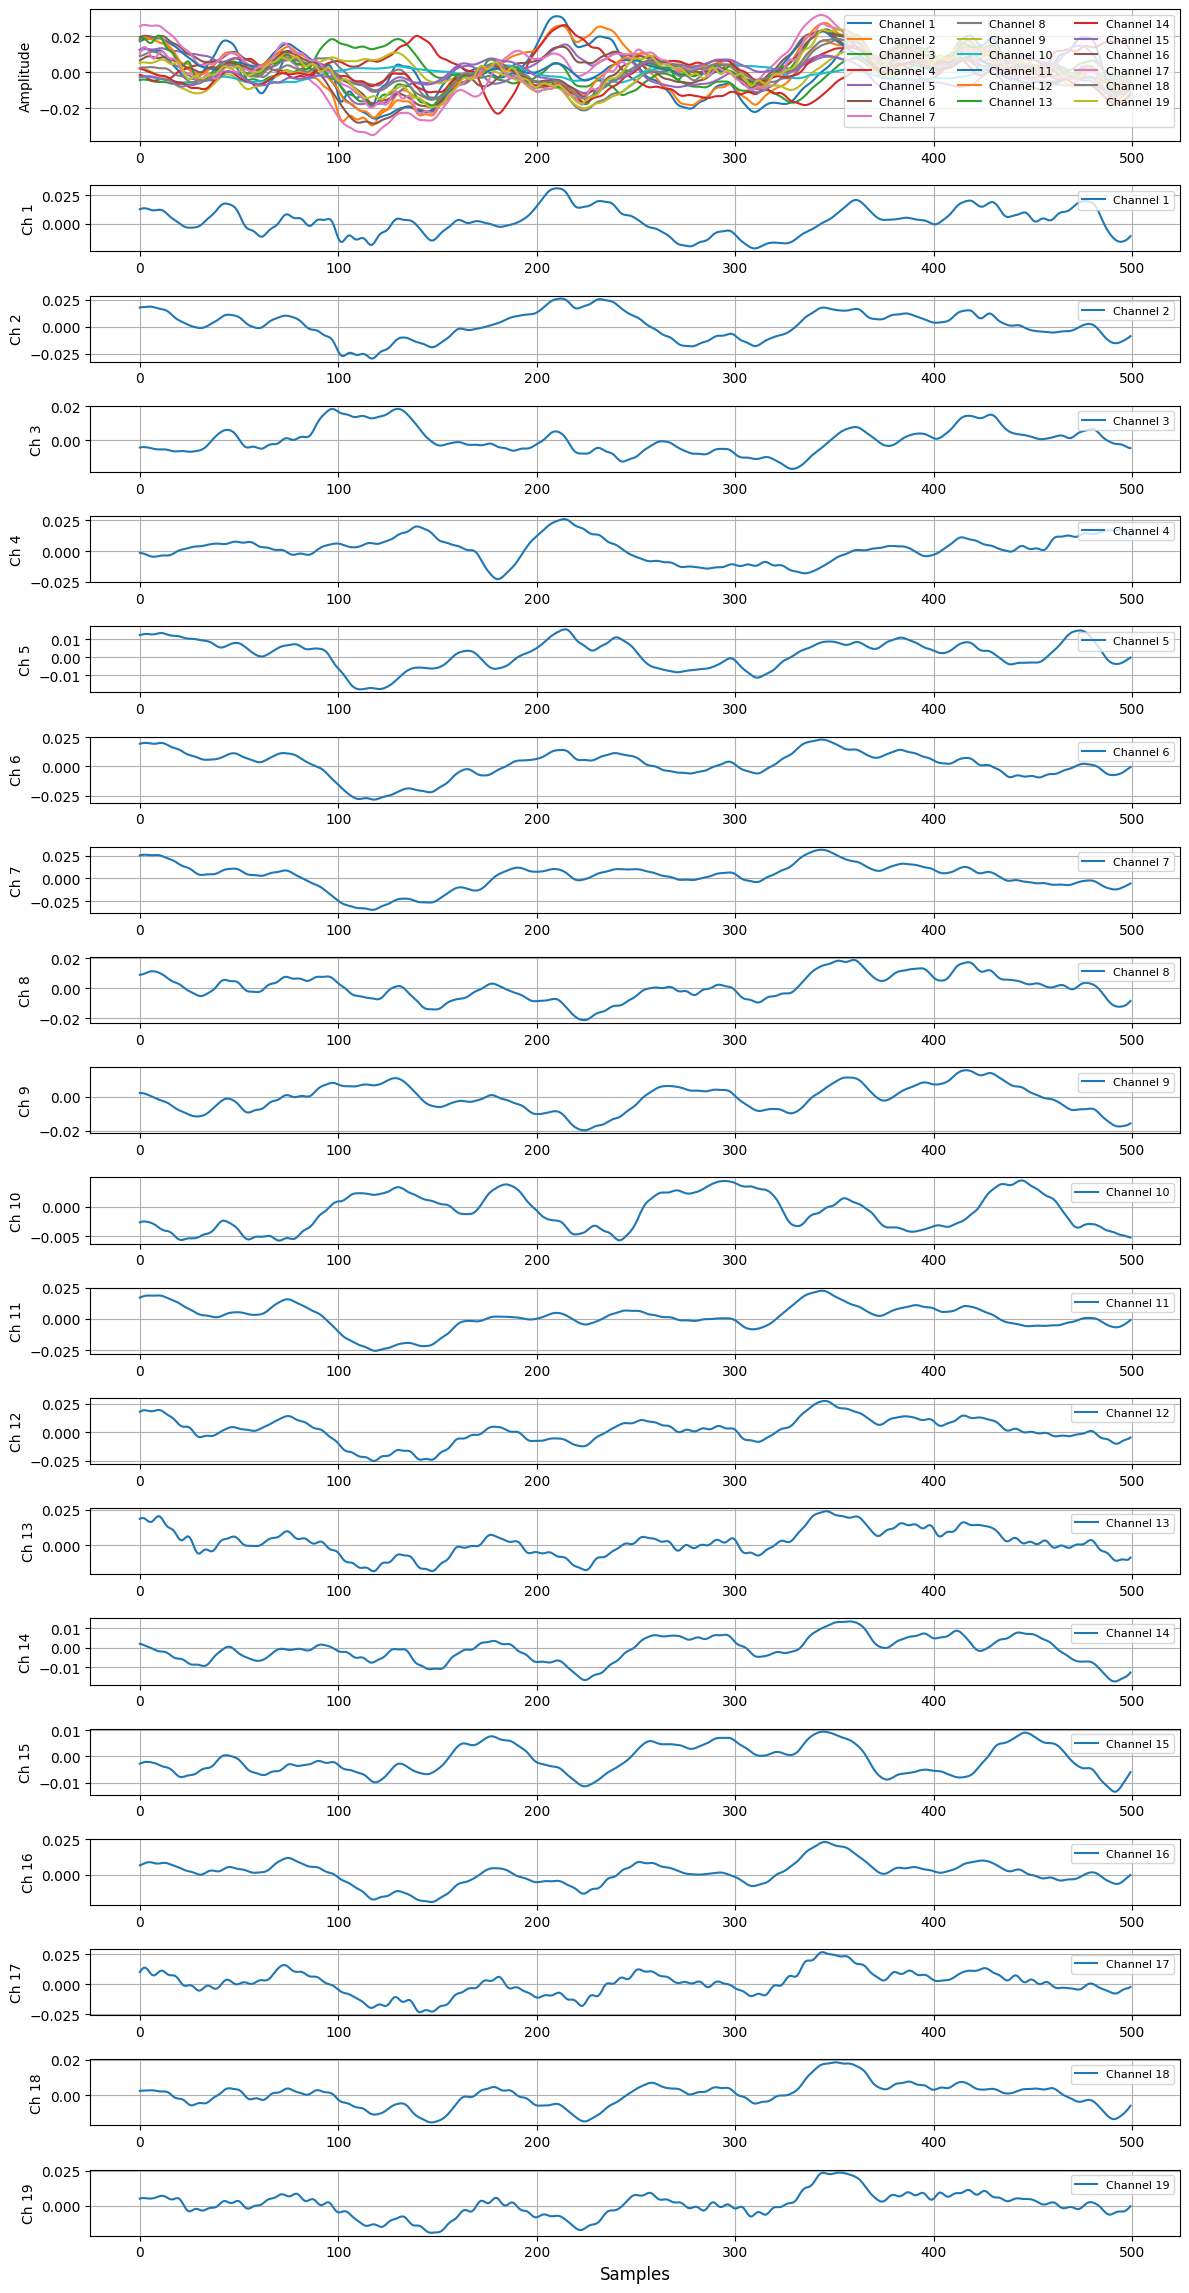

In [21]:
seizure = plot(seizure_data)

In [22]:
print("Time domain metrics of the normal data")
norm.describe()

Time domain metrics of the normal data


,Mean,Zero Crossing Rate,Range,Energy,RMS,Variance
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01
mean,0.000120,22.052632,0.011757,0.003816,0.002620,7.486601e-06
std,0.000372,10.351992,0.004233,0.002095,0.000899,4.127149e-06
min,-0.000455,13.000000,0.004486,0.000430,0.000927,8.373611e-07
25%,-0.000139,16.000000,0.008591,0.001924,0.001961,3.713337e-06
50%,0.000015,20.000000,0.013214,0.004820,0.003105,9.536430e-06
75%,0.000370,23.000000,0.014709,0.005231,0.003234,1.019342e-05
max,0.000953,55.000000,0.018219,0.007405,0.003848,1.460237e-05


In [23]:
print("Time domain metrics of the Complex_Partial_Seizures data")
cps.describe()

Time domain metrics of the Complex_Partial_Seizures data


,Mean,Zero Crossing Rate,Range,Energy,RMS,Variance
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01
mean,-0.000212,20.578947,0.044164,0.060234,0.009583,1.199780e-04
std,0.000686,15.004873,0.021574,0.065913,0.005499,1.315118e-04
min,-0.001450,7.000000,0.002136,0.000088,0.000419,1.732533e-07
25%,-0.000630,12.500000,0.033142,0.019678,0.006273,3.902852e-05
50%,-0.000089,15.000000,0.042786,0.042520,0.009222,8.396581e-05
75%,0.000226,24.500000,0.056732,0.079961,0.012562,1.596593e-04
max,0.000964,74.000000,0.093811,0.277556,0.023561,5.540710e-04


In [25]:
print("Time domain metrics of the Electrographic_Seizures data")
seizure.describe()

Time domain metrics of the Electrographic_Seizures data


,Mean,Zero Crossing Rate,Range,Energy,RMS,Variance
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.000699,12.315789,0.041870,0.045749,0.009209,0.000090
std,0.001064,3.317506,0.012893,0.024410,0.002659,0.000048
min,-0.001343,8.000000,0.010193,0.005161,0.003213,0.000010
25%,0.000129,9.500000,0.034500,0.030839,0.007853,0.000060
50%,0.001020,11.000000,0.042603,0.037531,0.008664,0.000074
75%,0.001560,14.000000,0.050842,0.058333,0.010795,0.000114
max,0.001915,19.000000,0.066498,0.103574,0.014393,0.000204


In [24]:
print("Time domain metrics of the Video_detected_Seizure data")
video.describe()

Time domain metrics of the Video_detected_Seizure data


,Mean,Zero Crossing Rate,Range,Energy,RMS,Variance
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.001399,59.789474,0.053254,0.057919,0.009326,0.000106
std,0.002912,19.778156,0.035310,0.063006,0.005520,0.000115
min,-0.000586,5.000000,0.013629,0.003694,0.002718,0.000007
25%,-0.000237,52.500000,0.028062,0.012670,0.004983,0.000025
50%,0.000543,63.000000,0.045145,0.039054,0.008838,0.000066
75%,0.001487,68.000000,0.072922,0.080226,0.012667,0.000146
max,0.011089,96.000000,0.158811,0.228629,0.021384,0.000457


In [17]:
# Compiling the features into a list
normaldat = []
cpsdat = []
videodat = []
seizuredat = []

for i in range(len(normaldataset)):
    data,_ = normaldataset[i]
    normaldat.append(calculateparams(data))
for i in range(len(cpsdataset)):
    data,_ = cpsdataset[i]
    cpsdat.append(calculateparams(data))
for i in range(len(videodataset)):
    data,_ = videodataset[i]
    videodat.append(calculateparams(data))
for i in range(len(seizuredataset)):
    data,_ = seizuredataset[i]
    seizuredat.append(calculateparams(data))

In [33]:
# Saving the Extracted Features

# Save features for each class to CSV files
def save_features_to_csv(features_list, file_name):
    """
    Save the compiled features into a CSV file.
    
    Args:
        features_list (list): List of feature dictionaries for a dataset.
        file_name (str): The name of the output CSV file.
    """
    # Flatten the nested list and convert to a DataFrame
    flattened_features = [item for sublist in features_list for item in sublist]
    df = pd.DataFrame(flattened_features)
    
    # Save to CSV
    df.to_csv(file_name, index=False)
    print(f"Features saved to {file_name}")


In [34]:
# Save features for each dataset
save_features_to_csv(normaldat, "normal_features.csv")
save_features_to_csv(cpsdat, "complex_partial_seizures_features.csv")
save_features_to_csv(videodat, "video_detected_seizures_features.csv")
save_features_to_csv(seizuredat, "electrographic_seizures_features.csv")

Features saved to normal_features.csv
Features saved to complex_partial_seizures_features.csv
Features saved to video_detected_seizures_features.csv
Features saved to electrographic_seizures_features.csv
